In [1]:
import uproot
import pandas as pd
import numpy as np
import boost_histogram as bh
import matplotlib.pyplot as plt
import pickle
import atlasplots as ap
%matplotlib inline

In [2]:
from sklearn.linear_model import SGDClassifier

In [3]:
df_gjfull = pickle.load(open('picklefiles/df_gj_800664.pickle', 'rb'))
df_jjfull = pickle.load(open('picklefiles/df_jj_801279.pickle', 'rb'))

In [4]:
df_jj = df_jjfull[~df_jjfull.y_isTruthMatchedPhoton]

combined = df_gjfull.append(df_jjfull)

In [5]:
### make X_train a matrix of the variables

X_train = np.array(combined[ap.branchlist]) #np.array(df_gjfull[ap.branchlist])

### make y_train of truth values

y_train = np.array(combined.y_isTruthMatchedPhoton) #np.array(df_gjfull.y_isTruthMatchedPhoton)

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [7]:
# np.shape(np.array(df_gjfull[ap.branchlist]))

In [8]:
# ap.branchlist

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8352792630210726
0.8403905835420534


KeyboardInterrupt: 

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
print(any(dummy_clf.predict(X_train)))  #prints False: no 5s detected



True


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"), cross_val_score(dummy_clf, X_train, y_train, cv=3, scoring="accuracy")

(array([0.84619808, 0.83053721, 0.82015007]),
 array([0.80296881, 0.80296964, 0.80296964]))

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
cm

array([[ 306012,  266521],
       [ 220797, 2112477]])

In [13]:
# confusion_matrix(y_train,dummy_clf.predict(X_train))

In [14]:
# confusion_matrix?

In [15]:
#Precision and Recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred), recall_score(y_train,y_train_pred)

(0.8879692206550825, 0.9053703079878317)

In [16]:
#Precision/Recall plots etc.
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

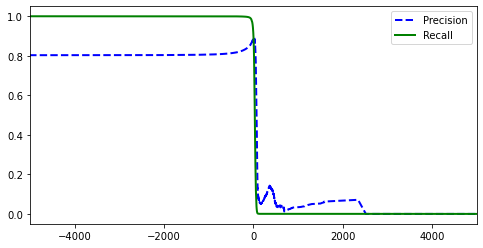

In [17]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.xlim(-5000,5000);plt.legend()
plt.show()


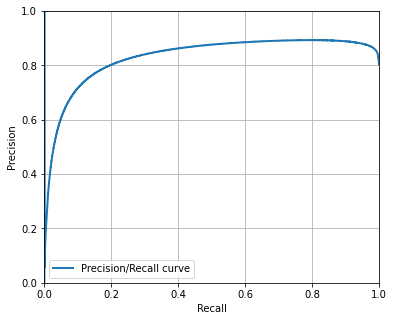

In [18]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# # extra code – just beautifies and saves Figure 3–6
# plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
# plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
# plt.plot([recalls[idx]], [precisions[idx]], "ko",
#          label="Point at threshold 3,000")
# plt.gca().add_patch(patches.FancyArrowPatch(
#     (0.79, 0.60), (0.61, 0.78),
#     connectionstyle="arc3,rad=.2",
#     arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
#     color="#444444"))
# plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
# save_fig("precision_vs_recall_plot")

plt.show()

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

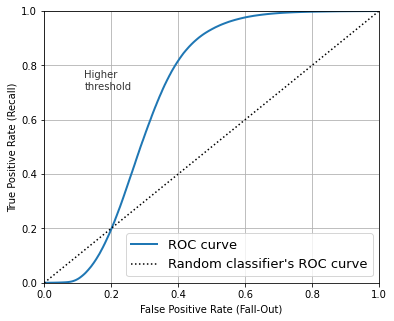

In [20]:
# idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
# tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
# plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# # extra code – just beautifies and saves Figure 3–7
# plt.gca().add_patch(patches.FancyArrowPatch(
#     (0.20, 0.89), (0.07, 0.70),
#     connectionstyle="arc3,rad=.4",
#     arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
#     color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
# save_fig("roc_curve_plot")

plt.show()